In [1]:
# SHAWN DIMANG RAS 557 ASSIGNMENT 5: PARAMETER IDENTIFICATION

### Beam Compare Values
![Values](CompareValues.png)

### Beam 1 Tracker
![Beam 1](beam1_tracker.png)

### Beam 2 Tracker
![Beam 2](beam2_tracker.png)

### Beam 3 Tracker
![Beam 3](beam3_tracker.png)


In [2]:
import os
import mujoco
import numpy
import mediapy as media
import matplotlib.pyplot as plt
import scipy.optimize as so


In [3]:
k_total = 2.1 #stiffness +k=+freq
b_total = .04 #damping
mass= .009 #mass of joint

In [4]:
main_template = """
<mujoco>
    <option gravity="0 0 -9.81">
    <flag contact="disable"/>
    </option>
    <worldbody>
        <light name="top" pos="0 0 1"/>
        <body name="body_1" pos="0 0 0">
            <joint name="joint_1" type="hinge" axis="0 1 0" pos="0 0 0" 
                stiffness="{k}" damping="{b}"/>
            <geom type="box" size="{l1_2} .025 .0005" pos="{l1_2} 0 0" rgba="0 1 0 1" 
            mass="{m}"/>
            {inner}
        </body>
    </worldbody>
</mujoco>
"""
body_template = '''
<body name="body_{ii}" pos="{l1} 0 0">
    <joint name="joint_{ii}" type="hinge" axis="0 1 0" pos="0 0 0" 
    stiffness="{k}" damping="{b}"/>
    <geom type="box" size="{l1_2} .025 .0005" pos="{l1_2} 0 0" rgba="1 0 0 1" mass="{m}"/>
    {inner}
</body>
'''

test_point='''
<geom type="sphere" size=".01" pos="{l1} 0 0" rgba="0 0 1 1" mass=".8"/>
'''


In [5]:
def run_sim(num_joints,k_i,b_i,m_total,render=False,show_video=False):
    n_joints = num_joints
    n_bodies = n_joints
    l = 1.2
    l_i=l/n_bodies
    m_i=m_total/n_bodies

    body_numbers = numpy.r_[n_bodies:1:-1]
   
    s=''
    for item in body_numbers:
        if item == body_numbers.max():
            s = body_template.format(inner=test_point.format(l1='{l1}'),ii=item,
                                    l1='{l1}',l1_2='{l1_2}',b='{b}',k='{k}',m='{m}')
    else:
        s = body_template.format(inner=s,ii=item,l1='{l1}',l1_2='{l1_2}',
                                b='{b}',k='{k}',m='{m}')
    
    s=main_template.format(inner = s,l1='{l1}',l1_2='{l1_2}',b='{b}',k='{k}',m='{m}')
   
    xml = s.format(l1=l_i,l1_2=l_i/2,k=k_i,b=b_i,m=m_i)
    
    model = mujoco.MjModel.from_xml_string(xml)
    data = mujoco.MjData(model)
    renderer = mujoco.Renderer(model)
    
    duration = 3 # (seconds)
    framerate = 30 # (Hz)
    
    q = []
    t = []
    xyz = []
    frames = []
    mujoco.mj_resetData(model, data)
    
    while data.time < duration:
        mujoco.mj_step(model, data)
        q.append(data.qpos.copy())
        xyz.append(data.xpos.copy())
        t.append(data.time)
        if render:
            if len(frames) < data.time * framerate:
                renderer.update_scene(data)
                pixels = renderer.render()
                frames.append(pixels)

    if render:
        if show_video:
            media.show_video(frames, fps=framerate,codec='gif')
    
    t = numpy.array(t)
    xyz = numpy.array(xyz)
    
    if render:
        return t, xyz, frames
    else:
        return t, xyz


""

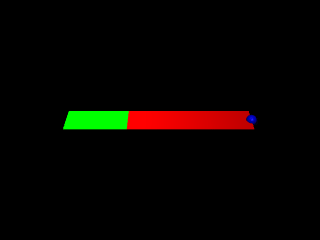

(np.float64(-0.5), np.float64(319.5), np.float64(239.5), np.float64(-0.5))

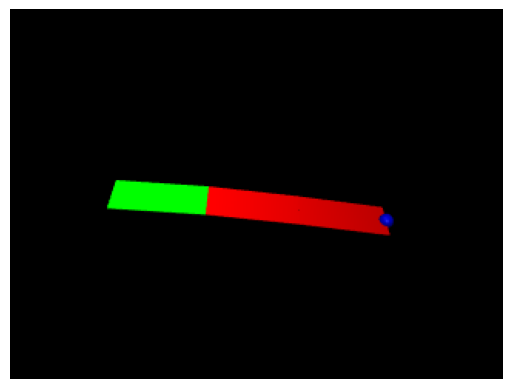

In [6]:
nn = 10
k_ii = 1/((1/k_total)/nn)
b_ii = 1/((1/b_total)/nn)
t,xyz_100_elements,frames_100_elements = run_sim(num_joints = nn,k_i = k_ii, b_i = b_ii,
                                                m_total=1,render=True,show_video=True)

plt.imshow(frames_100_elements[15])
plt.axis('off')

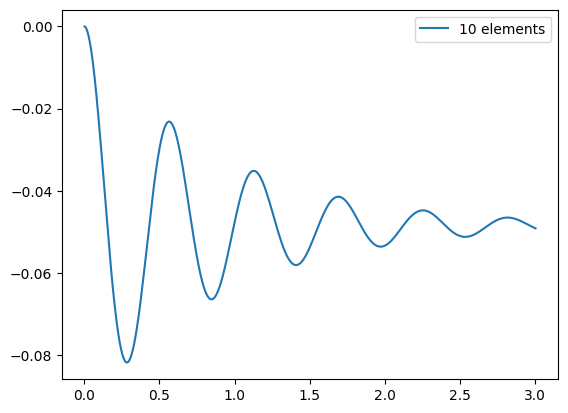

In [7]:
plt.figure()
plt.plot(t,xyz_100_elements[:,-1,2],label='10 elements')
plt.legend()

In [8]:
import numpy as np
import matplotlib.pyplot as plt

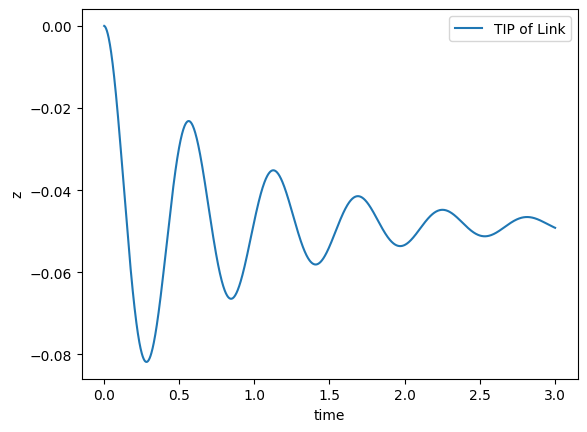

In [9]:
t_xyz = np.linspace(t.min(), t.max(), xyz_100_elements.shape[0])
z = xyz_100_elements[:, -1, 2]

plt.figure()
plt.plot(t_xyz, z, label="TIP of Link")
plt.legend()
plt.xlabel("time")
plt.ylabel("z")
plt.show()


In [10]:
import pandas as pd
import numpy
import matplotlib.pyplot as plt
import scipy.interpolate as si
df=pd.read_csv(r'C:\Users\shawn\OneDrive\Desktop\FOLDABLE ROBOTICS\beamdata.csv', sep=',', header=1)
print(df.columns)   # <-- see the real column names
print(df.head())    # <-- optional: see first few rows


Index(['t', 'x', 'y'], dtype='object')
        t      x       y
0  0.0000  0.254  0.0500
1  0.0167  0.254  0.0504
2  0.0334  0.254  0.0506
3  0.0501  0.254  0.0504
4  0.0669  0.254  0.0505


In [11]:
# TRACKER DATA input into jupyter lab 

Text(0, 0.5, 'Y')

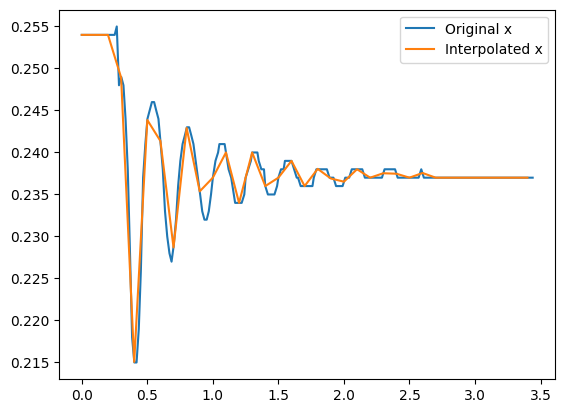

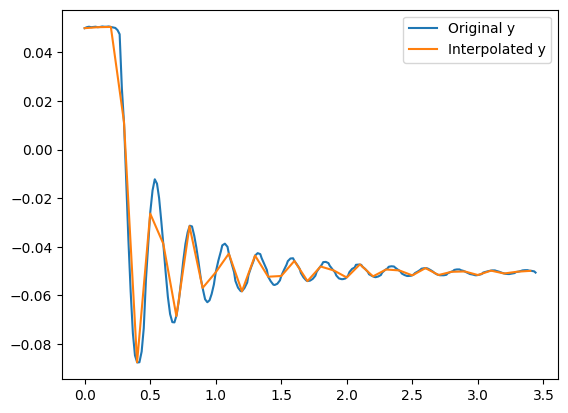

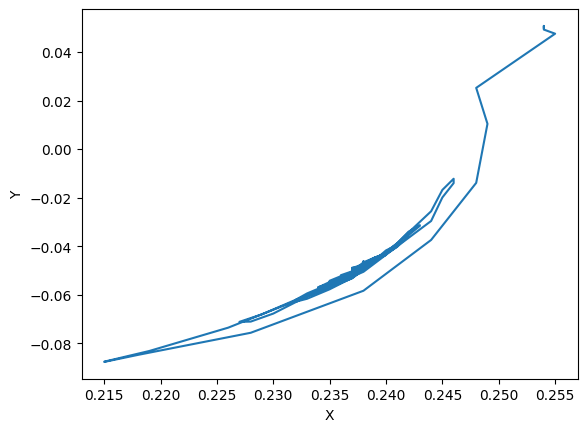

In [12]:
#x = df.x.astype('float64').to_numpy()
x = df.x.to_numpy()
y = df.y.to_numpy()
t = df.t.to_numpy()
xy = numpy.array([x,y]).T

f = si.interp1d(t,xy.T,fill_value='extrapolate',kind='quadratic')
new_t = numpy.r_[0:t[-1]:.1]
plt.figure()
plt.plot(t,x, label="Original x")
plt.plot(new_t,f(new_t)[0], label="Interpolated x")
plt.legend()

plt.figure()
plt.plot(t,y,label="Original y")
plt.plot(new_t,f(new_t)[1],label="Interpolated y")
plt.legend()

plt.figure()
plt.plot(x,y)
plt.xlabel("X")
plt.ylabel("Y")

In [13]:
print("t shape:", t.shape)
print("y shape:", y.shape)
print("xyz shape:", xyz_100_elements.shape)


t shape: (207,)
y shape: (207,)
xyz shape: (1501, 4, 3)


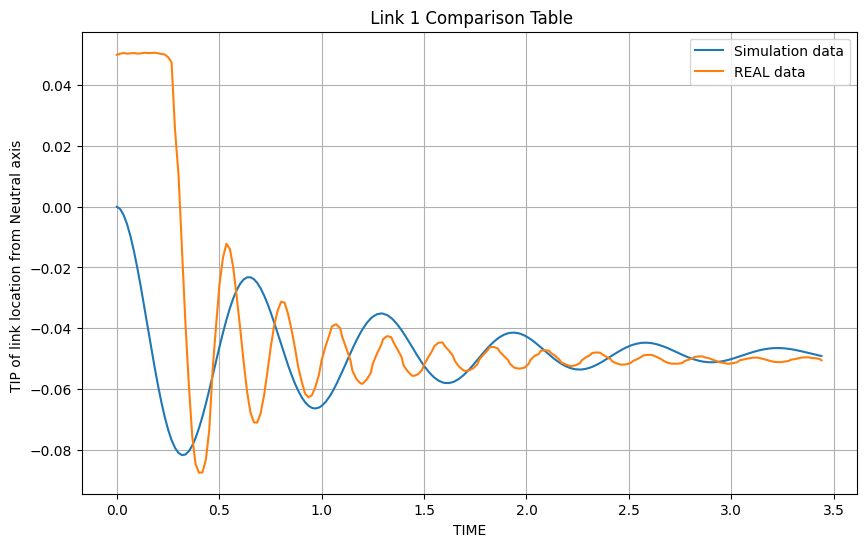

In [14]:
import numpy as np

# xyz time axis (1501 points)
t_xyz = np.linspace(t.min(), t.max(), xyz_100_elements.shape[0])

z10 = xyz_100_elements[:, -1, 2]

# Interpolate z10 onto the 207-point t
z10_interp = np.interp(t, t_xyz, z10)

plt.figure(figsize=(10, 6))
plt.title(" Link 1 Comparison Table")
plt.plot(t, z10_interp, label="Simulation data")
plt.plot(t, y, label="REAL data")
plt.legend()
plt.grid(True)
plt.xlabel("TIME")
plt.ylabel("TIP of link location from Neutral axis ")
plt.show()



In [15]:
# REAL DATA (TRACKER IN ORANGE) AND SIMULATION DATA (MUJOCO BLUE) Y VALUES

In [16]:
# FINAL GRAPHS FOR THE 2ND AND 3RD EXPERIMENT 

### LINK 2
![](LINK2.PNG)

### LINK 3
![](LINK3.PNG)